# Multiple infillers

Here we investigate three infillers that perform many cruncher operations. The first one is designed to infill all required data for running openSCM, with the minimum of inputs. One is designed to break down aggregate values, like the Kyoto gases or HFCs. The second does the opposite, recalculating aggregates from its components. These functions are purposefully not as object-oriented as the crunchers so that modellers unfamiliar with this coding structure can use them. 

You will need to install silicone in order to run this code. 

## Imports

In [1]:
import os.path
import traceback

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyam

import silicone.multiple_infillers as mi
from silicone.utils import (
    convert_units_to_MtCO2_equiv,
    get_sr15_scenarios,
    return_cases_which_consistently_split,
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
SR15_SCENARIOS = "./sr15_scenarios.csv"

## Example data

Here we pull some example data by downloading a selection of the SR1.5 scenarios.

In [3]:
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "IEA*",
    "IMAGE*",
    "MERGE*",
    "POLES*",
    "REMIND*",
    "WITCH*",
]
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS, valid_model_ids)

### Starting point

Our starting point is the test data, loaded as a `pyam.IamDataFrame`.

In [4]:
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
target = "Emissions|CO2"
constituents = ["Emissions|CO2|*"]
to_infill = sr15_data.filter(model="WITCH*", variable=[target] + constituents)
database = sr15_data.filter(model="WITCH*", keep=False)
to_infill.head()

pyam.core - INFO: Reading file `./sr15_scenarios.csv`


,model,scenario,region,variable,unit,year,meta,subannual,value
231183,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2005,0,0.0,31922.044350
231184,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2010,0,0.0,35303.387760
231185,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2020,0,0.0,37312.307110
231186,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2030,0,0.0,10560.008460
231187,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CO2,Mt CO2/yr,2040,0,0.0,7435.934987


## Investigating where the data is consistent

A utility function called return_cases_which_consistently_split indicates which variables consist of only other variables, which is useful to know in order to work out where data can be consistently split using decompose_collection_with_time_dep_ratio. Note that this is not a requirement for using that method (a consistent aggregate value is constructed in any case) but indicates that this is approach is rigorous. 

In the first instance, it does not find any results because there are several layers of constituents. However with only one layer, this works as expected. Note that if only one layer is used, there is also a pyam built-in function called 'check_consistency' that performs the same effect. 

In [5]:
no_cases = return_cases_which_consistently_split(
    to_infill, target, constituents,
)
len(no_cases)

0

However in the case below, we select only the next level of info, and find it matches in all cases (the number of cases does not depend on the accuracy, as shown in the second box. 

In [6]:
all_cases = return_cases_which_consistently_split(
    to_infill,
    target,
    ["Emissions|CO2|AFOLU", "Emissions|CO2|Energy and Industrial Processes"],
)
len(all_cases)

39

In [7]:
all_cases = return_cases_which_consistently_split(
    to_infill,
    target,
    ["Emissions|CO2|AFOLU", "Emissions|CO2|Energy and Industrial Processes"],
    how_close={
        "equal_nan": True,
        "rtol": 100,  # This means that we accept a factor of 100 inaccuracy.
    },
)
len(all_cases)

39

## Using the infiller functions
Here we show the use of the DecomposeCollectionTimeDepRatio and InfillAllRequiredVariables functions. 
### InfillAllRequiredVariables
This is a function to more conveniently infill all of the required variables that are not already found in the system. 

In [8]:
database.tail()

,model,scenario,region,variable,unit,year,meta,subannual,value
231123,REMIND-MAgPIE 1.7-3.0,SMP_REF_Sust,World,Emissions|VOC|Other,Mt VOC/yr,2060,0,0.0,23.2311
231124,REMIND-MAgPIE 1.7-3.0,SMP_REF_Sust,World,Emissions|VOC|Other,Mt VOC/yr,2070,0,0.0,22.1971
231125,REMIND-MAgPIE 1.7-3.0,SMP_REF_Sust,World,Emissions|VOC|Other,Mt VOC/yr,2080,0,0.0,21.1632
231126,REMIND-MAgPIE 1.7-3.0,SMP_REF_Sust,World,Emissions|VOC|Other,Mt VOC/yr,2090,0,0.0,20.1292
231127,REMIND-MAgPIE 1.7-3.0,SMP_REF_Sust,World,Emissions|VOC|Other,Mt VOC/yr,2100,0,0.0,19.0953


In [9]:
to_infill.tail()

,model,scenario,region,variable,unit,year,meta,subannual,value
244614,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2060,0,0.0,29487.271577
244615,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2070,0,0.0,31404.870008
244616,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2080,0,0.0,31911.146283
244617,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2090,0,0.0,30995.012917
244618,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr,2100,0,0.0,29852.454850


In [10]:
infilled = mi.infill_all_required_variables(
    to_infill, database, [target], output_timesteps=list(range(2020, 2101, 10))
)
infilled.head()

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:181: UserWarning: No data for ['Emissions|HFC|HFC245ca'], it will be infilled with 0s
  unavailable_variables
Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:16<00:00,  1.34it/s]


,model,scenario,region,variable,unit,year,meta,subannual,value
0,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2020,0,0.0,6.643665
1,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2030,0,0.0,5.032938
2,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2040,0,0.0,4.253773
3,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2050,0,0.0,3.641393
4,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|BC,Mt BC/yr,2060,0,0.0,3.198844


We now have a complete scenario, with all required variables. 

In [11]:
to_infill.filter().variables(True)

,variable,unit
0,Emissions|CO2,Mt CO2/yr
1,Emissions|CO2|AFOLU,Mt CO2/yr
2,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr
5,Emissions|CO2|Energy|Demand,Mt CO2/yr
8,Emissions|CO2|Energy|Demand|Industry,Mt CO2/yr
9,Emissions|CO2|Energy|Demand|Residential and Co...,Mt CO2/yr
6,Emissions|CO2|Energy|Demand|Transportation,Mt CO2/yr
3,Emissions|CO2|Energy|Supply,Mt CO2/yr
4,Emissions|CO2|Energy|Supply|Electricity,Mt CO2/yr
7,Emissions|CO2|Energy|Supply|Liquids,Mt CO2/yr


### DecomposeCollectionTimeDepRatio
This function is designed to split up an aggregate value into its known components, using the relationship between these found in models that have all components (but not necessarily the aggregate variable). The aggregate value is calculated in the first step. By default, data only present at a subset of the available times is not included in the analysis. 

In [12]:
database["unit"].unique()

array(['Mt BC/yr', 'Mt CH4/yr', 'Mt CO/yr', 'Mt CO2/yr',
       'Mt CO2-equiv/yr', 'kt HFC134a-equiv/yr', 'kt HFC125/yr',
       'kt HFC134a/yr', 'kt HFC143a/yr', 'kt HFC227ea/yr', 'kt HFC23/yr',
       'kt HFC32/yr', 'kt HFC43-10/yr', 'kt N2O/yr', 'Mt NH3/yr',
       'Mt NO2/yr', 'Mt OC/yr', 'kt CF4-equiv/yr', 'kt SF6/yr',
       'Mt SO2/yr', 'Mt VOC/yr', 'kt HFC245fa/yr', 'kt C2F6/yr',
       'kt C6F14/yr', 'kt CF4/yr'], dtype=object)

In [13]:
# Define some calculation parameters
components = [
    "Emissions|CO2",
    "Emissions|CH4",
    "Emissions|N2O",
    "Emissions|F-Gases",
]
aggregate = "Emissions|Kyoto Gases (AR4-GWP100)"
to_infill = sr15_data.filter(
    model="WITCH*", scenario="SSP1*", variable=aggregate
)
unit_consistent_db = convert_units_to_MtCO2_equiv(
    database.filter(variable=components)
)
unit_consistent_db.variables(True)

,variable,unit
0,Emissions|CH4,Mt CO2-equiv/yr
1,Emissions|CO2,Mt CO2/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,Mt CO2-equiv/yr


In [14]:
to_infill.variables(True)

,variable,unit
0,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr


In [15]:
decomposer = mi.DecomposeCollectionTimeDepRatio(unit_consistent_db.filter(year=[2000], keep=False))
results = decomposer.infill_components(
    aggregate, components, to_infill
)
results.head()

,model,scenario,region,variable,unit,year,subannual,meta,value
0,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2005,0.0,0,9114.811596
1,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2010,0.0,0,9763.633122
2,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2015,0.0,0,9638.068170
3,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2020,0.0,0,9511.952828
4,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CO2-equiv/yr,2030,0.0,0,3459.487892


In [16]:
# We now have variable information for each of the components
results.variables()

0        Emissions|CH4
1        Emissions|CO2
2    Emissions|F-Gases
3        Emissions|N2O
Name: variable, dtype: object

### SplitCollectionWithRemainderEmissions
This technique is also used for splitting up an aggregated basket of emissions, however does not assume that the emissions are in proportion to the aggregate at any given time. The key advantage of this is that it allows some emissions that are naturally limited to stay within their limits. The key disadvantage is that one of the emissions is only determined by conservation of the aggregate, and therefore may have quite a non-representative value. It is best for situations where one of the emissions is either very large compared to the others, or of unknown sign. This technique can be used with any cruncher, however the default is QRW. In most cases, CO$_2$ will be the emission to use as the 'remainder'. We will apply this technique to the same case as above, although we will not convert the units to be the same this time as the function will do this automatically. 

In [17]:
components = [
    "Emissions|CH4",
    "Emissions|N2O",
    "Emissions|F-Gases",
]
remainder = (
    "Emissions|CO2"  # This is the component that will make up the difference
)
aggregate = "Emissions|Kyoto Gases (AR4-GWP100)"
to_infill = sr15_data.filter(
    model="WITCH*", scenario="SSP1*", variable=aggregate
)
all_rem_vars = [remainder, aggregate] + components

In [18]:
split_remainder = mi.SplitCollectionWithRemainderEmissions(
    database.filter(variable=all_rem_vars)
)
remainder_split_res = split_remainder.infill_components(
    aggregate, components, remainder, to_infill, use_ar4_data=True,
)
remainder_split_res.head()

,model,scenario,region,variable,unit,year,subannual,meta,value
0,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2005,0.0,0,318.950322
1,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2010,0.0,0,352.500194
2,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2015,0.0,0,352.747965
3,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2020,0.0,0,345.695115
4,WITCH-GLOBIOM 3.1,SSP1-19,World,Emissions|CH4,Mt CH4/yr,2030,0.0,0,211.484876


We can compare this infilling method with that of the DecomposeCollectionTimeDepRatio method above. We plot them below, with the DecomposeCollection method dashed. 

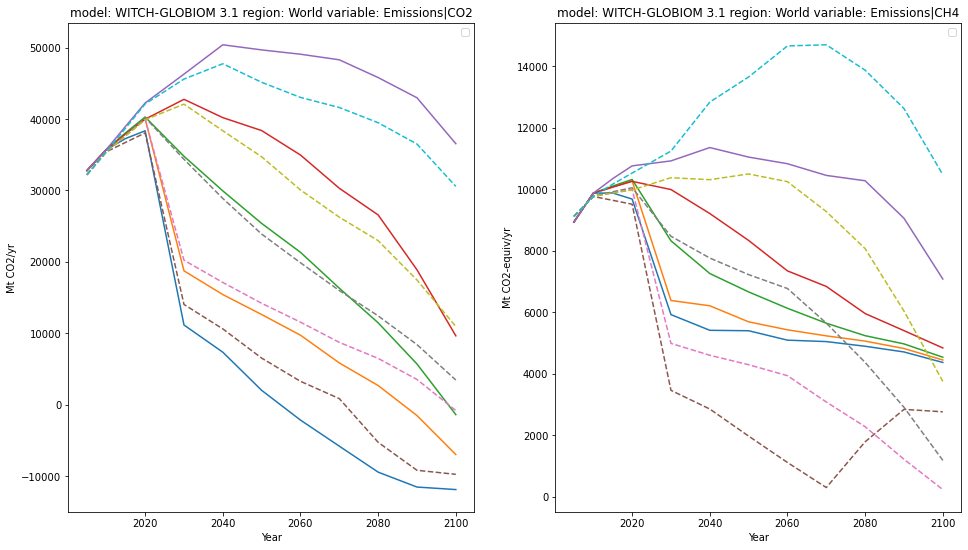

In [19]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
remainder_split_res.filter(variable="*CO2").line_plot(ax=ax, label="__")
results.filter(variable="*CO2").line_plot(ax=ax, linestyle="--", label="__")
ax = fig.add_subplot(122)
convert_units_to_MtCO2_equiv(
    remainder_split_res.filter(variable="*CH4")
).line_plot(ax=ax, label="__")
results.filter(variable="*CH4").line_plot(ax=ax, linestyle="--", label="__")

We see that the results are fairly similar for CO$_2$, since they make up the bulk of the aggregate in both cases. However the CH$_4$ results are very different, as they can take any positive value in the ratio-based technique, whereas it is constrained to keep to values in the infiller database in the QRW-based SplitCollection technique. This particularly results in regular behaviour when the lead values go negative, as seen in the lowermost curve on the right after 2070 - the methane level increases as the lead value becomes more negative for the DecomposeCollection method, whereas the (more expected) results from the SplitCollection method is a slow decline in emissions. 

### Calculate aggregate values
This tool is used to build an aggregate value that ensures that the data is self-consistent. In our case, the database has a value for F-Gases, but these aggregates are not consistent with the AR5 conversion factors. We select 'use_AR4=False' to use the AR5 values, which are the default. 

In [20]:
to_infill = sr15_data.filter(model="WITCH*")
target = "Emissions|F-Gases"
components = ["Emissions|HFC", "Emissions|PFC", "Emissions|SF6"]
valid_cases = return_cases_which_consistently_split(
    to_infill,
    target,
    components,
    use_ar4_data=False,
    how_close={"equal_nan": True, "rtol": 0.1,},
)
len(valid_cases)

0

We first convert them to a common unit.

In [21]:
to_infill = to_infill.filter(variable=[target] + components)
to_infill = convert_units_to_MtCO2_equiv(to_infill)
to_infill.filter(variable=target, scenario="ADVANCE_2020_Med2C").head()

,model,scenario,region,variable,unit,year,meta,subannual,value
237947,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2005,0,0.0,717.000054
237948,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2010,0,0.0,948.020176
237949,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2015,0,0.0,609.746591
237950,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2020,0,0.0,800.446286
237951,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2025,0,0.0,351.541200


The recalculated values are similar but noticably different:

In [22]:
infilled = mi.infill_composite_values(to_infill, {target: components})
infilled.filter(variable=target, scenario="ADVANCE_2020_Med2C").head()

,model,scenario,region,variable,unit,year,meta,subannual,value
20,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2005,0,0.0,610.958880
21,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2010,0,0.0,949.847085
22,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2015,0,0.0,567.248506
23,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2020,0,0.0,828.263273
24,WITCH-GLOBIOM 4.2,ADVANCE_2020_Med2C,World,Emissions|F-Gases,Mt CO2-equiv/yr,2025,0,0.0,307.759959


We have now fixed the inconsistency problem:

In [23]:
to_infill.filter(variable=target, keep=False, inplace=True)
to_infill.append(infilled, inplace=True)
valid_cases = return_cases_which_consistently_split(
    to_infill,
    target,
    components,
    use_ar4_data=True,
    how_close={"equal_nan": True, "rtol": 0.01,},
)
len(valid_cases)

9

In [24]:
len(to_infill.scenarios())

9

The `infill_composite_values` function can also take a dictionary of dictionaries as its second argument if the values should be multiplied by constants before summing them. This allows us to subtract values as well. 

In [25]:
aggregate = "Emissions|CO2|Other"
other_CO2 = mi.infill_composite_values(
    sr15_data,
    {
        aggregate: {
            "Emissions|CO2": 1,
            "Emissions|CO2|Energy and Industrial Processes": -1,
            "Emissions|CO2|AFOLU": -1,
        }
    },
)

In [26]:
other_CO2.head(10)

,model,scenario,region,variable,unit,year,meta,subannual,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2005,0,0.0,85.2526
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2010,0,0.0,89.6442
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2015,0,0.0,75.3558
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2020,0,0.0,78.3179
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2025,0,0.0,27.3933
5,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2030,0,0.0,20.0998
6,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2035,0,0.0,17.3219
7,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2040,0,0.0,15.2576
8,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2045,0,0.0,13.5058
9,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2|Other,Mt CO2/yr,2050,0,0.0,13.4414


These values are relatively small (cf. 34000 total emissions), so presumably represent rounding errors. 